In [19]:
from sklearnex import patch_sklearn
patch_sklearn()

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut

In [21]:
# Load the dataset
df = pd.read_csv('../Data/final_data.csv')

# Define the columns (Keep site_name here for splitting, but we must protect it)
features = [
    'site_name', 'rye_biomass', 'year', 'fall_N_rate', 'spring_N_rate', 'row_id',
    'num_days_fall', 'num_days_spring', 'num_cold_days_fall', 'num_cold_days_spring',
    'num_cold_days_winter', 'total_cold_days', 'frequency_cold_days',
    'RHavg_avg_fall', 'RHavg_avg_spring', 'RHavg_avg_winter', 'VPD_avg_fall',
    'VPD_avg_spring', 'VPD_avg_winter', 'PAR_sum_fall', 'PAR_sum_spring',
    'PAR_sum_winter', 'GDD_sum_fall', 'GDD_sum_spring', 'GDD_sum_winter',
    'FDD_sum_fall', 'FDD_sum_spring', 'FDD_sum_winter', 'rain_plant',
    'rain_sum_fall', 'rain_sum_spring', 'rain_sum_winter', 'ET0_sum_fall',
    'ET0_sum_spring', 'ET0_sum_winter'
]

# Create the subset
df_model = df[features].copy()

# --- DATA CLEANING ---
# Coerce numeric columns. PROTECT 'site_name' and 'year' from this!
for col in features:
    if col not in ['year', 'site_name']:  # <--- FIXED: Added site_name to exclusion
         df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# Drop rows with NaN values (now safe because site_name is still text)
df_model = df_model.dropna()
print(f"Data shape after cleaning: {df_model.shape}")

Data shape after cleaning: (1073, 35)


In [22]:
# --- SPLIT LOGIC ---
# 1. Identify multi-year sites and their last year
site_stats = df_model.groupby('site_name')['year'].agg(['nunique', 'max'])
multi_year_sites = site_stats[site_stats['nunique'] > 1]['max'].to_dict()

# 2. Create Validation Mask
def is_val(row):
    return row['site_name'] in multi_year_sites and row['year'] == multi_year_sites[row['site_name']]

val_mask = df_model.apply(is_val, axis=1)

# 3. Create Sets & Drop site_name
val_data = df_model[val_mask].drop(columns=['site_name'])
temp_data = df_model[~val_mask].drop(columns=['site_name'])

train_data, test_data = train_test_split(temp_data, test_size=0.2, random_state=42)

# Verify
print(f"Validation: {val_data.shape}")
print(f"Train: {train_data.shape}, Test: {test_data.shape}")

Validation: (243, 34)
Train: (664, 34), Test: (166, 34)


In [28]:
val_data

,rye_biomass,year,fall_N_rate,spring_N_rate,row_id,num_days_fall,num_days_spring,num_cold_days_fall,num_cold_days_spring,num_cold_days_winter,...,FDD_sum_fall,FDD_sum_spring,FDD_sum_winter,rain_plant,rain_sum_fall,rain_sum_spring,rain_sum_winter,ET0_sum_fall,ET0_sum_spring,ET0_sum_winter
14,1773.333333,2008-2009,0.0,0.0,15,42,69,15,7,81,...,28.0,38.4,674.05,94.7,89.1,228.8,60.3,99.1,290.3,102.8
15,1426.666667,2008-2009,0.0,0.0,16,42,69,15,7,81,...,28.0,38.4,674.05,94.7,89.1,228.8,60.3,99.1,290.3,102.8
16,1186.666667,2008-2009,0.0,0.0,17,42,69,15,7,81,...,28.0,38.4,674.05,94.7,89.1,228.8,60.3,99.1,290.3,102.8
17,1446.666667,2008-2009,0.0,0.0,18,42,69,15,7,81,...,28.0,38.4,674.05,94.7,89.1,228.8,60.3,99.1,290.3,102.8
18,913.333333,2008-2009,0.0,0.0,19,42,69,15,7,81,...,28.0,38.4,674.05,94.7,89.1,228.8,60.3,99.1,290.3,102.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,4493.440000,2023-2024,0.0,0.0,1105,54,46,0,0,3,...,0.0,0.0,9.00,34.6,60.6,220.7,502.4,212.4,239.3,285.2
1105,14863.520000,2023-2024,0.0,0.0,1106,54,76,0,0,3,...,0.0,0.0,9.00,34.6,60.6,370.8,502.4,212.4,401.2,285.2
1106,17403.680000,2023-2024,0.0,0.0,1107,54,76,0,0,3,...,0.0,0.0,9.00,34.6,60.6,370.8,502.4,212.4,401.2,285.2
1109,2307.200000,2023-2024,0.0,0.0,1110,43,15,0,0,4,...,0.0,0.0,15.30,46.9,57.3,0.5,343.3,172.0,83.1,355.0


In [23]:
# --- REMOVE IDENTIFIERS FROM PREDICTORS ---
# Exclude target, year, and row_id from the feature set
predictors = [c for c in features if c not in ['rye_biomass', 'year', 'row_id', 'site_name']]

print(f"Predictors used ({len(predictors)}): {predictors}")

X_train, y_train = train_data[predictors], train_data['rye_biomass']
X_test, y_test = test_data[predictors], test_data['rye_biomass']
X_val, y_val = val_data[predictors], val_data['rye_biomass']

Predictors used (31): ['fall_N_rate', 'spring_N_rate', 'num_days_fall', 'num_days_spring', 'num_cold_days_fall', 'num_cold_days_spring', 'num_cold_days_winter', 'total_cold_days', 'frequency_cold_days', 'RHavg_avg_fall', 'RHavg_avg_spring', 'RHavg_avg_winter', 'VPD_avg_fall', 'VPD_avg_spring', 'VPD_avg_winter', 'PAR_sum_fall', 'PAR_sum_spring', 'PAR_sum_winter', 'GDD_sum_fall', 'GDD_sum_spring', 'GDD_sum_winter', 'FDD_sum_fall', 'FDD_sum_spring', 'FDD_sum_winter', 'rain_plant', 'rain_sum_fall', 'rain_sum_spring', 'rain_sum_winter', 'ET0_sum_fall', 'ET0_sum_spring', 'ET0_sum_winter']


In [24]:
# --- STRATEGY 1: LOG TRANSFORM TARGET ---
# Reduces impact of outliers and normalizes distribution
y_train_log = np.log1p(y_train)

# --- STRATEGY 2: EXTRACT GROUPS FOR CV ---
# We need 'year' to group folds, preventing data leakage during tuning
groups_train = train_data['year']

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


In [25]:
# Define Group Splitter
gkf = GroupKFold(n_splits=5) # Splits based on 'year', not random rows

# 1. RFECV with GroupKFold
print(f"Running RFECV with GroupKFold...")
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
rfecv = RFECV(
    estimator=rf_base,
    step=1,
    cv=gkf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Pass groups=groups_train to ensure years are held out
rfecv.fit(X_train_scaled, y_train_log, groups=groups_train)

print(f"Optimal features: {rfecv.n_features_}")
selected_feat = [predictors[i] for i in range(len(predictors)) if rfecv.support_[i]]
print(f"Selected: {selected_feat}")

X_train_opt = rfecv.transform(X_train_scaled)
X_test_opt = rfecv.transform(X_test_scaled)
X_val_opt = rfecv.transform(X_val_scaled)

Running RFECV with GroupKFold...
Optimal features: 24
Selected: ['fall_N_rate', 'num_days_fall', 'num_days_spring', 'num_cold_days_spring', 'frequency_cold_days', 'RHavg_avg_fall', 'RHavg_avg_spring', 'RHavg_avg_winter', 'VPD_avg_fall', 'VPD_avg_spring', 'PAR_sum_fall', 'PAR_sum_spring', 'PAR_sum_winter', 'GDD_sum_fall', 'GDD_sum_spring', 'GDD_sum_winter', 'FDD_sum_winter', 'rain_plant', 'rain_sum_fall', 'rain_sum_spring', 'rain_sum_winter', 'ET0_sum_fall', 'ET0_sum_spring', 'ET0_sum_winter']


In [26]:
# 2. Grid Search with GroupKFold
print("\nStarting Hyperparameter Tuning with GroupKFold...")

param_grid = {
    'n_estimators': [50, 100], 
    'max_depth': list(range(3, 15, 7)),
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [4, 8, 12],
    'max_features': ['sqrt', 0.3]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=1), 
    param_grid=param_grid,
    cv=gkf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_opt, y_train_log, groups=groups_train)
best_rf = grid_search.best_estimator_
print(f"Best Params: {grid_search.best_params_}")


# Evaluate
# IMPORTANT: Inverse transform predictions (exp) to get back to biomass units
y_train_pred = np.expm1(best_rf.predict(X_train_opt))
y_test_pred = np.expm1(best_rf.predict(X_test_opt))
y_val_pred = np.expm1(best_rf.predict(X_val_opt))

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("\n--- Final Performance (Log-Transformed + GroupCV) ---")
print(f"Test R2: {r2_score(y_test, y_test_pred):.4f}, RMSE: {test_rmse:.4f}")
print(f"Val R2:  {r2_score(y_val, y_val_pred):.4f}, RMSE: {val_rmse:.4f}")


Starting Hyperparameter Tuning with GroupKFold...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

--- Final Performance (Log-Transformed + GroupCV) ---
Test R2: 0.7663, RMSE: 1407.4461
Val R2:  0.0228, RMSE: 3314.8875


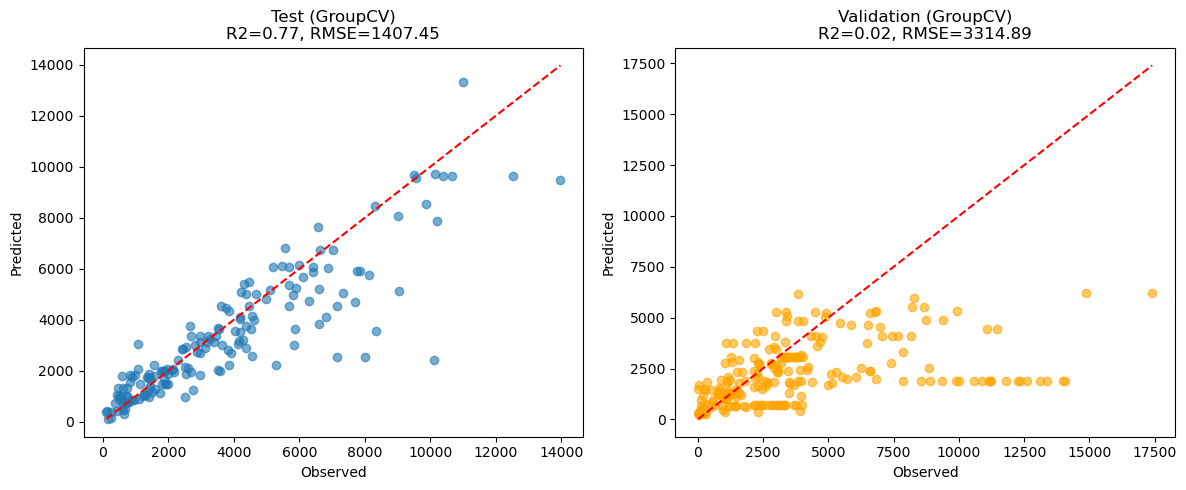

In [27]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(y_test, y_test_pred, alpha=0.6)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax1.set_title(f'Test (GroupCV)\nR2={r2_score(y_test, y_test_pred):.2f}, RMSE={test_rmse:.2f}')
ax1.set_xlabel('Observed')
ax1.set_ylabel('Predicted')

ax2.scatter(y_val, y_val_pred, alpha=0.6, color='orange')
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
ax2.set_title(f'Validation (GroupCV)\nR2={r2_score(y_val, y_val_pred):.2f}, RMSE={val_rmse:.2f}')
ax2.set_xlabel('Observed')
ax2.set_ylabel('Predicted')

plt.tight_layout()
plt.show()